In [1]:




import pandas as pd
import numpy as np
# Read the Crashes dataset
crashes_df = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes_20240425 (1).csv')

# Print the first few rows
print("First few rows of Crashes Dataset:\n", crashes_df.head())

# Check for missing values
print("\nMissing values in Crashes Dataset:\n", crashes_df.isnull().sum())

# Check data types
print("\nData types in Crashes Dataset:\n", crashes_df.dtypes)

# Get summary statistics
print("\nSummary statistics of Crashes Dataset:\n", crashes_df.describe())

First few rows of Crashes Dataset:
    CRASH DATE CRASH TIME   BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0  2021-09-11   09:35:00  BROOKLYN   11208.0  40.667202 -73.866500   
1  2021-12-14   08:13:00  BROOKLYN   11233.0  40.683304 -73.917274   
2  2021-12-14   17:05:00  BROOKLYN       NaN  40.709183 -73.956825   
3  2021-12-14   08:17:00     BRONX   10475.0  40.868160 -73.831480   
4  2021-12-14   21:10:00  BROOKLYN   11207.0  40.671720 -73.897100   

                  LOCATION              ON STREET NAME CROSS STREET NAME  \
0    (40.667202, -73.8665)                         NaN               NaN   
1  (40.683304, -73.917274)             SARATOGA AVENUE    DECATUR STREET   
2  (40.709183, -73.956825)  BROOKLYN QUEENS EXPRESSWAY               NaN   
3    (40.86816, -73.83148)                         NaN               NaN   
4     (40.67172, -73.8971)                         NaN               NaN   

               OFF STREET NAME  ...  NUMBER OF CYCLIST KILLED  \
0      1211      LORI

In [3]:
# Convert CRASH DATE column to datetime
crashes_df['CRASH DATE'] = pd.to_datetime(crashes_df['CRASH DATE'], errors='coerce')

# Convert CRASH TIME column to time
crashes_df['CRASH TIME'] = pd.to_datetime(crashes_df['CRASH TIME'], format='%H:%M', errors='coerce').dt.time

In [4]:
# Drop rows with missing values in LATITUDE and LONGITUDE columns
crashes_df = crashes_df.dropna(subset=['LATITUDE', 'LONGITUDE'], how='any')

In [5]:
# Identify numerical columns
numeric_cols = crashes_df.select_dtypes(include=['float64', 'int64']).columns

# Calculate Z-scores for numerical columns
z_scores = crashes_df[numeric_cols].apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# Identify outliers based on a threshold (e.g., abs(z_score) > 3)
outliers = (np.abs(z_scores) > 3).any(axis=1)

# Print the number of outliers
print(f"Number of outliers: {outliers.sum()}")

Number of outliers: 101321


In [6]:
print("New shape of DataFrame:", crashes_df.shape)
print("\nRemaining missing values:\n", crashes_df.isnull().sum())

New shape of DataFrame: (973776, 29)

Remaining missing values:
 CRASH DATE                            0
CRASH TIME                            0
BOROUGH                          321952
ZIP CODE                         322120
LATITUDE                              0
LONGITUDE                             0
LOCATION                              0
ON STREET NAME                   248618
CROSS STREET NAME                508589
OFF STREET NAME                  725757
NUMBER OF PERSONS INJURED            15
NUMBER OF PERSONS KILLED             27
NUMBER OF PEDESTRIANS INJURED         0
NUMBER OF PEDESTRIANS KILLED          0
NUMBER OF CYCLIST INJURED             0
NUMBER OF CYCLIST KILLED              0
NUMBER OF MOTORIST INJURED            0
NUMBER OF MOTORIST KILLED             0
CONTRIBUTING FACTOR VEHICLE 1      3571
CONTRIBUTING FACTOR VEHICLE 2    167055
CONTRIBUTING FACTOR VEHICLE 3    902304
CONTRIBUTING FACTOR VEHICLE 4    957008
CONTRIBUTING FACTOR VEHICLE 5    969044
COLLISION_ID   

In [6]:
# Filter the DataFrame to get the outliers
outlier_rows = crashes_df[outliers]
print("Sample of outlier rows:\n", outlier_rows.head())

Sample of outlier rows:
    CRASH DATE CRASH TIME   BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
16 2021-12-14   20:03:00  BROOKLYN   11226.0  40.650680 -73.958810   
23 2021-12-14   03:43:00       NaN       NaN  40.804375 -73.937420   
25 2021-12-14   17:31:00  BROOKLYN   11230.0  40.623104 -73.958090   
27 2021-12-14   12:54:00  BROOKLYN   11217.0  40.687534 -73.977500   
31 2021-12-14   16:25:00       NaN       NaN  40.784615 -73.953964   

                   LOCATION    ON STREET NAME   CROSS STREET NAME  \
16    (40.65068, -73.95881)               NaN                 NaN   
23   (40.804375, -73.93742)  LEXINGTON AVENUE                 NaN   
25   (40.623104, -73.95809)    EAST 18 STREET            AVENUE K   
27    (40.687534, -73.9775)     FULTON STREET  SAINT FELIX STREET   
31  (40.784615, -73.953964)    EAST 93 STREET                 NaN   

              OFF STREET NAME  ...   CONTRIBUTING FACTOR VEHICLE 2  \
16  878       FLATBUSH AVENUE  ...                             NaN   

In [7]:
import geopandas as gpd

# Load the borough boundary shapefile
borough_boundaries = gpd.read_file('Borough Boundaries/geo_export_cf18a34c-d00f-430a-a1d8-d4cd7fe9705b.shp')

# Convert the crashes DataFrame to a GeoDataFrame
crashes_gdf = gpd.GeoDataFrame(crashes_df, geometry=gpd.points_from_xy(crashes_df['LONGITUDE'], crashes_df['LATITUDE']))

In [9]:
crashes_df['BOROUGH'] = crashes_gdf['BOROUGH']  # Replace 'borough_column_name' with the actual column name from the shapefile

In [10]:
print(crashes_df['BOROUGH'].isnull().sum())

324816


In [11]:
import geopandas as gpd

# Load the borough boundary shapefile
borough_boundaries = gpd.read_file('Borough Boundaries/geo_export_cf18a34c-d00f-430a-a1d8-d4cd7fe9705b.shp')

# Filter the crashes DataFrame to include only rows with non-missing latitude and longitude
crashes_with_coords = crashes_df[crashes_df['LATITUDE'].notnull() & crashes_df['LONGITUDE'].notnull()].copy()

# Convert the filtered crashes DataFrame to a GeoDataFrame
crashes_gdf = gpd.GeoDataFrame(crashes_with_coords, geometry=gpd.points_from_xy(crashes_with_coords['LONGITUDE'], crashes_with_coords['LATITUDE']))

# Set the coordinate reference system (CRS) to match the borough boundaries
crashes_gdf.crs = borough_boundaries.crs

# Perform spatial join
crashes_gdf = gpd.sjoin(crashes_gdf, borough_boundaries, op='within')

# Update the BOROUGH column in the original DataFrame
crashes_df.loc[crashes_gdf.index, 'BOROUGH'] = crashes_gdf['BOROUGH']  # Replace 'BoroName' with the actual column name from the shapefile

# Fill the remaining missing values in the BOROUGH column with 'Unknown'
crashes_df['BOROUGH'].fillna('Unknown', inplace=True)

# Check the missing values in the BOROUGH column
print(crashes_df['BOROUGH'].isnull().sum())

/Users/gouthamvemula/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


0


In [16]:
print(borough_boundaries.columns)

Index(['boro_code', 'boro_name', 'shape_area', 'shape_leng', 'geometry'], dtype='object')


In [ ]:
from shapely.geometry import Point

def assign_borough(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return 'Unknown'
    
    point = Point(lon, lat)
    
    for _, row in borough_boundaries.iterrows():
        if row['geometry'].contains(point):
            return row['boro_name']  # Replace 'boro_column_name' with the correct column name
    
    return 'Unknown'

crashes_df['BOROUGH'] = crashes_df.apply(lambda row: assign_borough(row['LATITUDE'], row['LONGITUDE']), axis=1)

In [7]:
print("Borough distribution:")
print(crashes_df['BOROUGH'].value_counts())

Borough distribution:
BROOKLYN         213837
QUEENS           181810
MANHATTAN        125914
BRONX            105840
STATEN ISLAND     24423
Name: BOROUGH, dtype: int64


In [8]:
# Save the crashes_df DataFrame to a new CSV file
crashes_df.to_csv('cleaned_crashes_data.csv', index=False)

In [2]:
# Load the cleaned crashes data from the CSV file
cleaned_crashes_df = pd.read_csv('standardized_cleaned_crashes_data.csv')

# Check the first few rows of the cleaned data
print("First few rows of the cleaned data:")
print(cleaned_crashes_df.head())

# Check the data types of the columns
print("\nData types of the columns:")
print(cleaned_crashes_df.dtypes)

# Check for missing values
print("\nMissing values in each column:")
print(cleaned_crashes_df.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows:")
print(cleaned_crashes_df.duplicated().sum())

# Check for any obvious inconsistencies or anomalies
# You can perform specific checks based on your domain knowledge and understanding of the data

First few rows of the cleaned data:
   CRASH DATE CRASH TIME   BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0  2021-09-11   09:35:00  BROOKLYN   11208.0  40.667202 -73.866500   
1  2021-12-14   08:13:00  BROOKLYN   11233.0  40.683304 -73.917274   
2  2021-12-14   17:05:00  BROOKLYN       NaN  40.709183 -73.956825   
3  2021-12-14   08:17:00     BRONX   10475.0  40.868160 -73.831480   
4  2021-12-14   21:10:00  BROOKLYN   11207.0  40.671720 -73.897100   

                  LOCATION              ON STREET NAME CROSS STREET NAME  \
0    (40.667202, -73.8665)                         NaN               NaN   
1  (40.683304, -73.917274)             SARATOGA AVENUE    DECATUR STREET   
2  (40.709183, -73.956825)  BROOKLYN QUEENS EXPRESSWAY               NaN   
3    (40.86816, -73.83148)                         NaN               NaN   
4     (40.67172, -73.8971)                         NaN               NaN   

               OFF STREET NAME  ...  NUMBER OF CYCLIST KILLED  \
0      1211      LORI

In [6]:
# Load the cleaned crashes data from the CSV file
cleaned_crashes_df = pd.read_csv('standardized_cleaned_crashes_data.csv')

# Check the first few rows of the cleaned data
print("First few rows of the cleaned data:")
print(cleaned_crashes_df.head())

# Check the data types of the columns
print("\nData types of the columns:")
print(cleaned_crashes_df.dtypes)

# Check for missing values
print("\nMissing values in each column:")
print(cleaned_crashes_df.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows:")
print(cleaned_crashes_df.duplicated().sum())

First few rows of the cleaned data:
   CRASH DATE CRASH TIME   BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0  2021-09-11   09:35:00  BROOKLYN   11208.0  40.667202 -73.866500   
1  2021-12-14   08:13:00  BROOKLYN   11233.0  40.683304 -73.917274   
2  2021-12-14   17:05:00  BROOKLYN   11207.0  40.709183 -73.956825   
3  2021-12-14   08:17:00     BRONX   10475.0  40.868160 -73.831480   
4  2021-12-14   21:10:00  BROOKLYN   11207.0  40.671720 -73.897100   

                  LOCATION              ON STREET NAME CROSS STREET NAME  \
0    (40.667202, -73.8665)                     Unknown           Unknown   
1  (40.683304, -73.917274)             SARATOGA AVENUE    DECATUR STREET   
2  (40.709183, -73.956825)  BROOKLYN QUEENS EXPRESSWAY           Unknown   
3    (40.86816, -73.83148)                     Unknown           Unknown   
4     (40.67172, -73.8971)                     Unknown           Unknown   

               OFF STREET NAME  ...  NUMBER OF CYCLIST KILLED  \
0      1211      LORI

In [3]:
import pandas as pd

# Load the cleaned crashes data from the CSV file
df = pd.read_csv('standardized_cleaned_crashes_data.csv')

# Group by borough and find the most common ZIP code for each borough
borough_zip = df.groupby('BOROUGH')['ZIP CODE'].agg(pd.Series.mode).to_dict()

# Impute missing ZIP code values with the most common ZIP code in the corresponding borough
def impute_zip_code(row):
    if pd.isnull(row['ZIP CODE']):
        borough = row['BOROUGH']
        if borough in borough_zip:
            return borough_zip[borough]
    return row['ZIP CODE']

df['ZIP CODE'] = df.apply(impute_zip_code, axis=1)

# Save the updated DataFrame to the same CSV file
df.to_csv('standardized_cleaned_crashes_data.csv', index=False)

In [5]:
import pandas as pd

cleaned_crashes_df['CRASH DATE'] = pd.to_datetime(cleaned_crashes_df['CRASH DATE'])
cleaned_crashes_df['CRASH TIME'] = pd.to_datetime(cleaned_crashes_df['CRASH TIME'], format='%H:%M:%S').dt.time

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim

# Load the cleaned crashes data from the CSV file
df = pd.read_csv('standardized_cleaned_crashes_data.csv')

# Create a geocoder object
geolocator = Nominatim(user_agent="crashes_analysis")

def impute_zip_code(row):
    if pd.isnull(row['ZIP CODE']):
        lat, lon = row['LATITUDE'], row['LONGITUDE']
        if pd.notnull(lat) and pd.notnull(lon):
            try:
                location = geolocator.reverse(f"{lat}, {lon}")
                zip_code = location.raw['address'].get('postcode')
                return zip_code
            except:
                return None
    return row['ZIP CODE']

# Impute missing ZIP code values
df['ZIP CODE'] = df.apply(impute_zip_code, axis=1)

# Save the updated DataFrame to the same CSV file
df.to_csv('standardized_cleaned_crashes_data.csv', index=False)

In [5]:
import pandas as pd

# Load the cleaned crashes data from the CSV file
df = pd.read_csv('standardized_cleaned_crashes_data.csv')

# Impute missing street names with 'Unknown'
df['ON STREET NAME'].fillna('Unknown', inplace=True)
df['CROSS STREET NAME'].fillna('Unknown', inplace=True)
df['OFF STREET NAME'].fillna('Unknown', inplace=True)

# Save the updated DataFrame to the same CSV file
df.to_csv('standardized_cleaned_crashes_data.csv', index=False)

In [19]:
print("Borough distribution:")
print(cleaned_crashes_df['BOROUGH'].value_counts())

Borough distribution:
BROOKLYN         213837
QUEENS           181810
MANHATTAN        125914
BRONX            105840
Queens            97420
Brooklyn          83154
Manhattan         58857
Bronx             53323
STATEN ISLAND     24423
Staten Island     21550
Unknown            7648
Name: BOROUGH, dtype: int64


In [20]:
import pandas as pd

# Load the cleaned crashes data from the CSV file
cleaned_crashes_df = pd.read_csv('improved_cleaned_crashes_data.csv')

# Create a mapping dictionary for borough names
borough_mapping = {
    'BROOKLYN': 'BROOKLYN',
    'Brooklyn': 'BROOKLYN',
    'QUEENS': 'QUEENS',
    'Queens': 'QUEENS',
    'MANHATTAN': 'MANHATTAN',
    'Manhattan': 'MANHATTAN',
    'BRONX': 'BRONX',
    'Bronx': 'BRONX',
    'STATEN ISLAND': 'STATEN ISLAND',
    'Staten Island': 'STATEN ISLAND'
}

# Standardize the borough names using the mapping dictionary
cleaned_crashes_df['BOROUGH'] = cleaned_crashes_df['BOROUGH'].map(borough_mapping)

# Convert 'CRASH DATE' and 'CRASH TIME' columns to datetime format
cleaned_crashes_df['CRASH DATE'] = pd.to_datetime(cleaned_crashes_df['CRASH DATE'])
cleaned_crashes_df['CRASH TIME'] = pd.to_datetime(cleaned_crashes_df['CRASH TIME'], format='%H:%M:%S').dt.time

# Save the updated cleaned data to a new CSV file
cleaned_crashes_df.to_csv('standardized_cleaned_crashes_data.csv', index=False)

# Print the updated borough distribution
print("Updated Borough Distribution:")
print(cleaned_crashes_df['BOROUGH'].value_counts())

Updated Borough Distribution:
BROOKLYN         296991
QUEENS           279230
MANHATTAN        184771
BRONX            159163
STATEN ISLAND     45973
Name: BOROUGH, dtype: int64


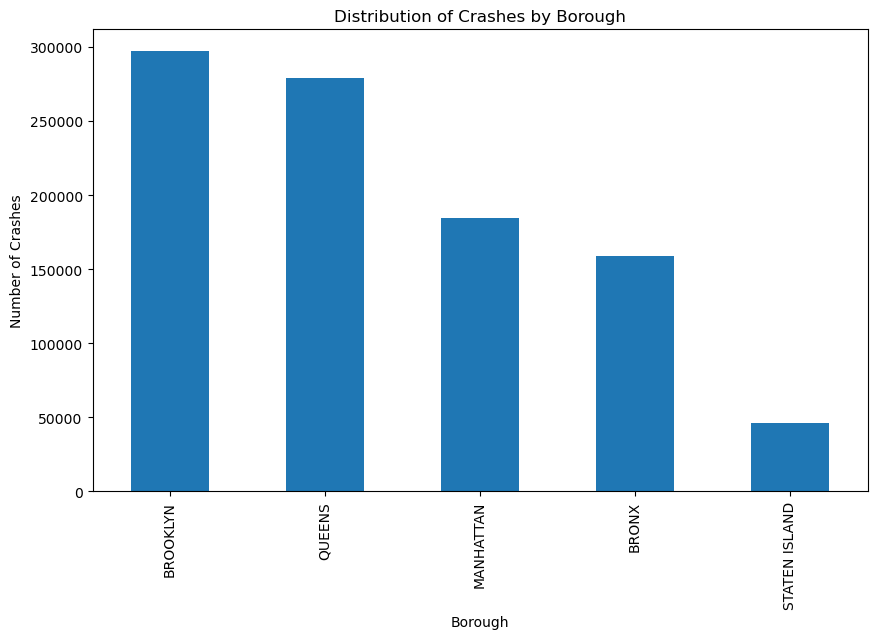

In [21]:
import matplotlib.pyplot as plt

# Load the standardized cleaned crashes data from the CSV file
df = pd.read_csv('standardized_cleaned_crashes_data.csv')

# Plot the distribution of crashes by borough
plt.figure(figsize=(10, 6))
df['BOROUGH'].value_counts().plot(kind='bar')
plt.xlabel('Borough')
plt.ylabel('Number of Crashes')
plt.title('Distribution of Crashes by Borough')
plt.show()

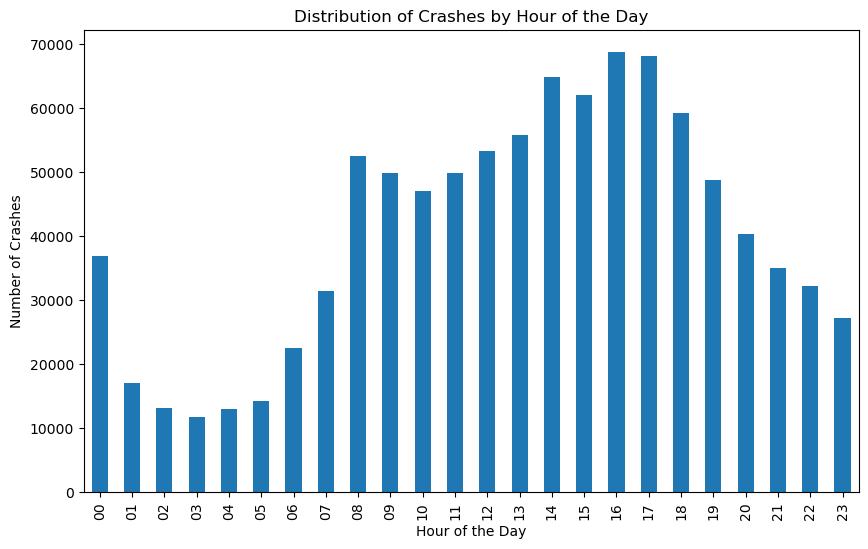

In [22]:
# Convert 'CRASH TIME' column to datetime
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M:%S').dt.time

# Plot the distribution of crashes by hour of the day
plt.figure(figsize=(10, 6))
df['CRASH TIME'].astype(str).str[:2].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crashes')
plt.title('Distribution of Crashes by Hour of the Day')
plt.show()

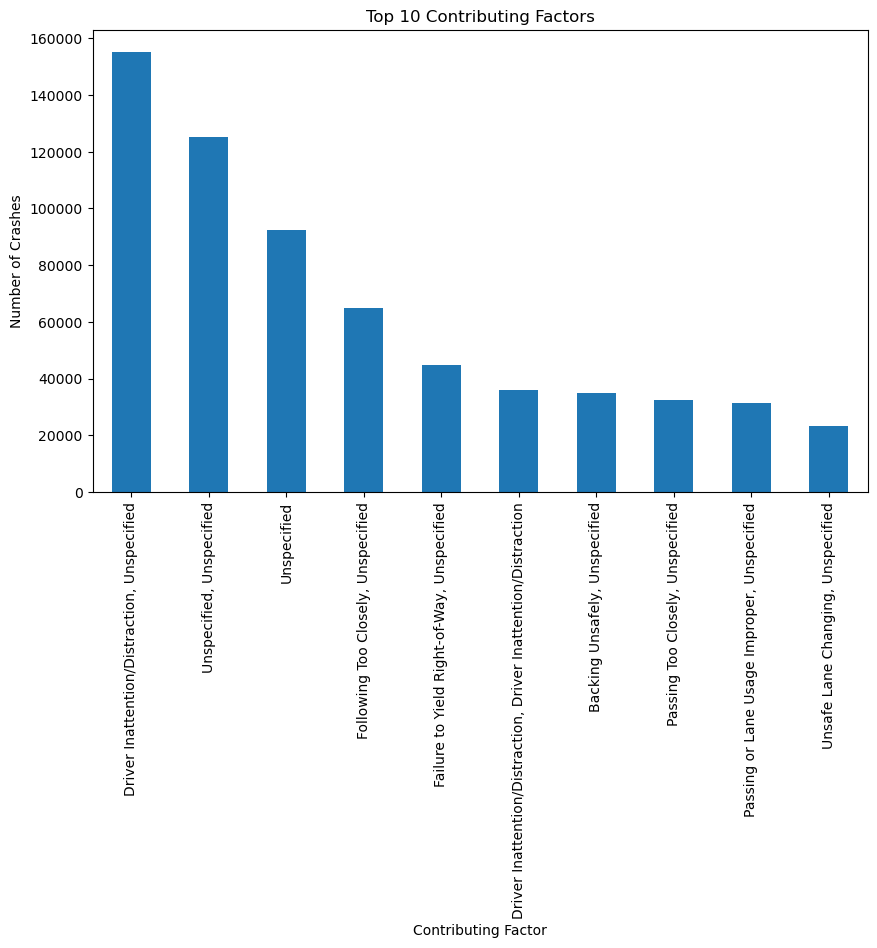

In [23]:
# Plot the distribution of contributing factors
plt.figure(figsize=(10, 6))
df['CONTRIBUTING FACTORS'].value_counts().nlargest(10).plot(kind='bar')
plt.xlabel('Contributing Factor')
plt.ylabel('Number of Crashes')
plt.title('Top 10 Contributing Factors')
plt.show()

/var/folders/ql/mdczd2813cz2wkhh2fqqh36m0000gn/T/ipykernel_11089/2601696122.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

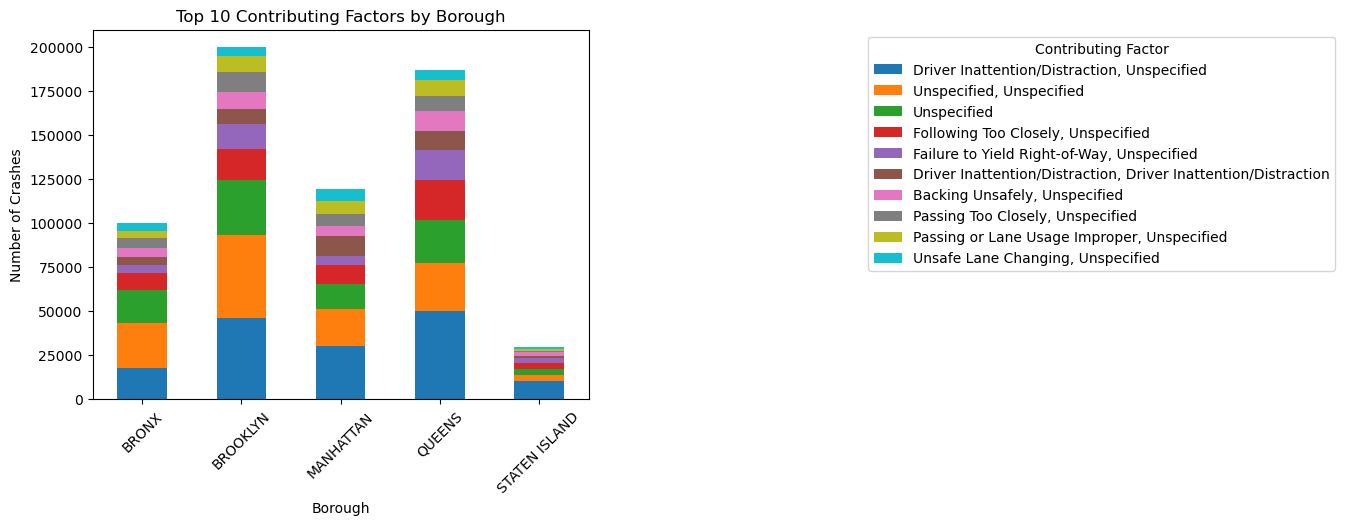

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the standardized cleaned crashes data from the CSV file
df = pd.read_csv('standardized_cleaned_crashes_data.csv')

# Create a crosstab of borough and top 10 contributing factors
top_factors = df['CONTRIBUTING FACTORS'].value_counts().nlargest(10).index
crosstab = pd.crosstab(df['BOROUGH'], df['CONTRIBUTING FACTORS'])[top_factors]

# Plot the crosstab as a stacked bar chart
plt.figure(figsize=(12, 6))
crosstab.plot(kind='bar', stacked=True)
plt.xlabel('Borough')
plt.ylabel('Number of Crashes')
plt.title('Top 10 Contributing Factors by Borough')
plt.legend(title='Contributing Factor', bbox_to_anchor=(1.55, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

First few rows of the dataset:
   CRASH DATE CRASH TIME   BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0  2021-09-11   09:35:00  BROOKLYN   11208.0  40.667202 -73.866500   
1  2021-12-14   08:13:00  BROOKLYN   11233.0  40.683304 -73.917274   
2  2021-12-14   17:05:00  BROOKLYN   11207.0  40.709183 -73.956825   
3  2021-12-14   08:17:00     BRONX   10475.0  40.868160 -73.831480   
4  2021-12-14   21:10:00  BROOKLYN   11207.0  40.671720 -73.897100   

                  LOCATION              ON STREET NAME CROSS STREET NAME  \
0    (40.667202, -73.8665)                     Unknown           Unknown   
1  (40.683304, -73.917274)             SARATOGA AVENUE    DECATUR STREET   
2  (40.709183, -73.956825)  BROOKLYN QUEENS EXPRESSWAY           Unknown   
3    (40.86816, -73.83148)                     Unknown           Unknown   
4     (40.67172, -73.8971)                     Unknown           Unknown   

               OFF STREET NAME  ...  NUMBER OF CYCLIST KILLED  \
0      1211      LORING AV

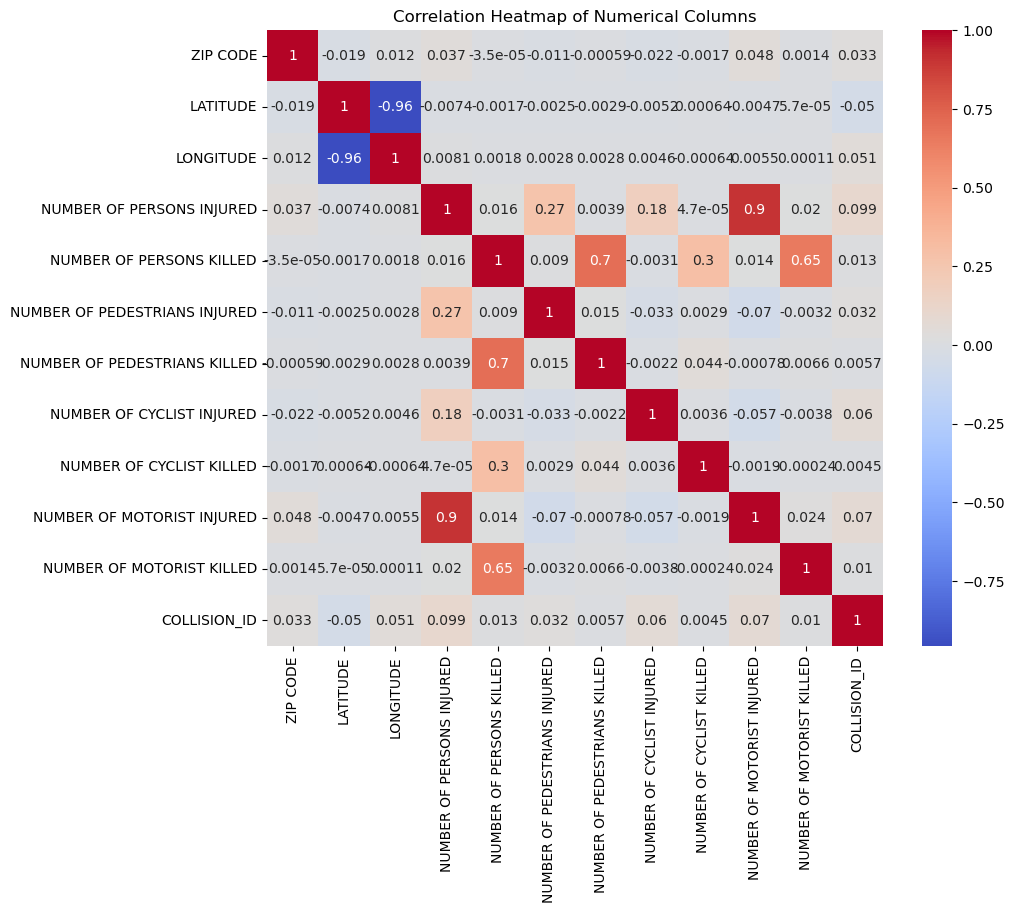

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned crashes data from the CSV file
df = pd.read_csv('mv_crashes_cleaned.csv')

# Print the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Get information about the dataset
print("\nDataset information:")
print(df.info())

# Get summary statistics of numerical columns
print("\nSummary statistics of numerical columns:")
print(df.describe())

# Check missing values in each column
print("\nMissing values in each column:")
print(df.isnull().sum())

# Plot the heatmap of correlation between numerical columns
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()